# Liquid Neural Network

In [41]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [42]:

# ==========================================
# 0. GPU SETUP
# ==========================================
# Automatically detect if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. DATASET GENERATION
# ==========================================
def generate_irregular_data(n_samples=1000, seq_len=20):
    X = []
    Y = []
    T = [] 

    for _ in range(n_samples):
        start = np.random.rand() * 10
        dt = np.random.rand(seq_len) * 0.9 + 0.1 
        t_steps = np.cumsum(dt) + start
        
        y = np.sin(t_steps)
        
        x_seq = y[:-1]
        y_seq = y[1:]
        t_seq = dt[1:] 
        
        X.append(x_seq[:, None]) 
        Y.append(y_seq[:, None])
        T.append(t_seq[:, None])

    # Convert to Tensors and IMMEDIATELY move to the selected device (GPU/CPU)
    return (torch.FloatTensor(np.array(X)).to(device), 
            torch.FloatTensor(np.array(Y)).to(device), 
            torch.FloatTensor(np.array(T)).to(device))

Using device: cuda


## LNN

In [43]:
# ==========================================
# 2. THE LIQUID NEURAL NETWORK (LTC Cell)
# ==========================================
class LiquidTC(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LiquidTC, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.w_base = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.A = nn.Parameter(torch.ones(1, hidden_dim))
        self.tau = nn.Parameter(torch.ones(1, hidden_dim))

    def forward(self, x, t_deltas, h_prev):
        combined = torch.cat([h_prev, x], dim=1)
        f_out = torch.sigmoid(self.w_base(combined))
        
        numerator = h_prev + t_deltas * f_out * self.A
        denominator = 1 + t_deltas * (1/torch.abs(self.tau) + f_out)
        
        h_new = numerator / denominator
        return h_new

class LNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LNN_Model, self).__init__()
        self.rnn_cell = LiquidTC(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, t):
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden state on the SAME device as input x
        h = torch.zeros(batch_size, self.rnn_cell.hidden_dim).to(x.device)
        
        outputs = []
        for i in range(seq_len):
            h = self.rnn_cell(x[:, i, :], t[:, i, :], h)
            outputs.append(h)
            
        outputs = torch.stack(outputs, dim=1)
        return self.fc_out(outputs)

## RNN

In [44]:
# ==========================================
# 3. STANDARD COMPETITORS
# ==========================================
class StandardRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StandardRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, t=None): 
        out, _ = self.rnn(x)
        return self.fc(out)

## LSTM

In [45]:
class StandardLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StandardLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, t=None): 
        out, _ = self.lstm(x)
        return self.fc(out)

## Training Loop

In [46]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_model(model, name, X, Y, T, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    losses = []
    
    start_time = time.time()
    
    for i in range(epochs):
        optimizer.zero_grad()
        
        if name == "LNN":
            pred = model(X, T)
        else:
            pred = model(X)
            
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if i % 10 == 0:
            print(f"[{name}] Epoch {i}: Loss {loss.item():.5f}")
            
    print(f"[{name}] Finished in {time.time()-start_time:.2f}s")
    return losses, pred

## Model Training

In [47]:
# ==========================================
# 5. EXECUTION & PLOTTING
# ==========================================
# Generate Data (It will auto-move to GPU inside the function)
X, Y, T = generate_irregular_data(n_samples=200, seq_len=30)
input_dim = 1
hidden_dim = 16
output_dim = 1

# Initialize Models and MOVE TO DEVICE
lnn = LNN_Model(input_dim, hidden_dim, output_dim).to(device)
rnn = StandardRNN(input_dim, hidden_dim, output_dim).to(device)
lstm = StandardLSTM(input_dim, hidden_dim, output_dim).to(device)

print(f"--- Training on {device} ---")
print("--- Training LNN ---")
loss_lnn, pred_lnn = train_model(lnn, "LNN", X, Y, T, epochs=500)
print("\n--- Training RNN ---")
loss_rnn, pred_rnn = train_model(rnn, "RNN", X, Y, T, epochs=500)
print("\n--- Training LSTM ---")
loss_lstm, pred_lstm = train_model(lstm, "LSTM", X, Y, T, epochs=500)

--- Training on cuda ---
--- Training LNN ---
[LNN] Epoch 0: Loss 0.69882
[LNN] Epoch 10: Loss 0.51357
[LNN] Epoch 20: Loss 0.48714
[LNN] Epoch 30: Loss 0.48273
[LNN] Epoch 40: Loss 0.47020
[LNN] Epoch 50: Loss 0.45800
[LNN] Epoch 60: Loss 0.44177
[LNN] Epoch 70: Loss 0.41918
[LNN] Epoch 80: Loss 0.38828
[LNN] Epoch 90: Loss 0.34745
[LNN] Epoch 100: Loss 0.29671
[LNN] Epoch 110: Loss 0.23915
[LNN] Epoch 120: Loss 0.17927
[LNN] Epoch 130: Loss 0.11925
[LNN] Epoch 140: Loss 0.06263
[LNN] Epoch 150: Loss 0.03023
[LNN] Epoch 160: Loss 0.02855
[LNN] Epoch 170: Loss 0.02348
[LNN] Epoch 180: Loss 0.02300
[LNN] Epoch 190: Loss 0.02220
[LNN] Epoch 200: Loss 0.02211
[LNN] Epoch 210: Loss 0.02195
[LNN] Epoch 220: Loss 0.02188
[LNN] Epoch 230: Loss 0.02180
[LNN] Epoch 240: Loss 0.02174
[LNN] Epoch 250: Loss 0.02168
[LNN] Epoch 260: Loss 0.02163
[LNN] Epoch 270: Loss 0.02158
[LNN] Epoch 280: Loss 0.02153
[LNN] Epoch 290: Loss 0.02148
[LNN] Epoch 300: Loss 0.02144
[LNN] Epoch 310: Loss 0.02139
[LNN]

## Evaluation

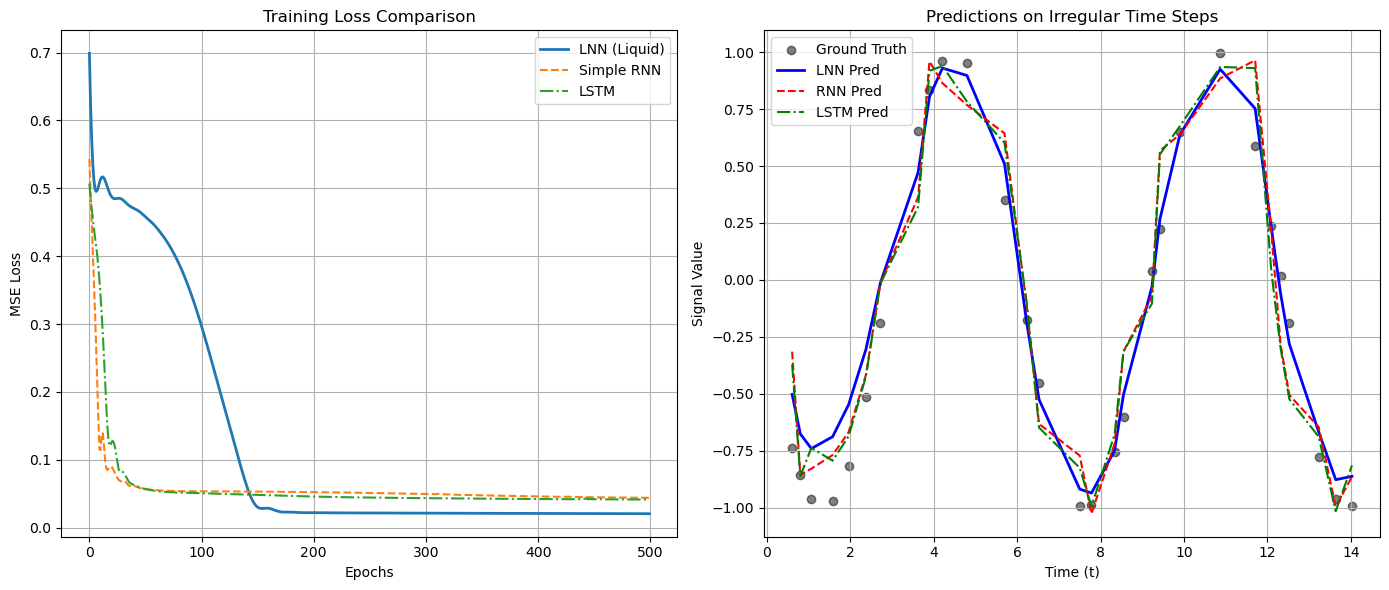

In [48]:

# ==========================================
# PLOTTING (Move data back to CPU)
# ==========================================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_lnn, label='LNN (Liquid)', linewidth=2)
plt.plot(loss_rnn, label='Simple RNN', linestyle='--')
plt.plot(loss_lstm, label='LSTM', linestyle='-.')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sample_idx = 0

# IMPORTANT: .cpu() moves data from GPU to CPU
# .detach() removes it from the gradient graph so numpy can read it
# We use .numpy() to convert Tensor to Number array for Matplotlib
time_axis = np.cumsum(T[sample_idx].cpu().numpy()) 

plt.scatter(time_axis, Y[sample_idx].cpu().numpy(), label='Ground Truth', color='black', alpha=0.5)
plt.plot(time_axis, pred_lnn[sample_idx].cpu().detach().numpy(), label='LNN Pred', color='blue', linewidth=2)
plt.plot(time_axis, pred_rnn[sample_idx].cpu().detach().numpy(), label='RNN Pred', color='red', linestyle='--')
plt.plot(time_axis, pred_lstm[sample_idx].cpu().detach().numpy(), label='LSTM Pred', color='green', linestyle='-.')
plt.title('Predictions on Irregular Time Steps')
plt.xlabel('Time (t)')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Advanced Architectures

### LNN

In [13]:
# Re-using your Liquid Cell (The Improved V2 you just used)
class LiquidTC_Improved(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LiquidTC_Improved, self).__init__()
        self.hidden_dim = hidden_dim
        self.w_base = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.A = nn.Parameter(torch.ones(1, hidden_dim))
        self.tau_param = nn.Parameter(torch.Tensor(1, hidden_dim).uniform_(0.1, 1))
        nn.init.xavier_uniform_(self.w_base.weight)
        nn.init.zeros_(self.w_base.bias)

    def forward(self, x, t_deltas, h_prev):
        combined = torch.cat([h_prev, x], dim=1)
        f_out = torch.sigmoid(self.w_base(combined))
        tau = torch.nn.functional.softplus(self.tau_param) + 0.1
        numerator = h_prev + t_deltas * f_out * self.A
        denominator = 1 + t_deltas * (1/tau + f_out)
        return numerator / denominator

# ==========================================
# 1. ADVANCED LNN: Stacked Liquid Network
# ==========================================
class AdvancedLNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(AdvancedLNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Create a list of Liquid Cells (Layer 1, Layer 2, ...)
        # Layer 1 takes 'input_dim', subsequent layers take 'hidden_dim'
        self.cells = nn.ModuleList()
        self.cells.append(LiquidTC_Improved(input_dim, hidden_dim))
        for _ in range(1, num_layers):
            self.cells.append(LiquidTC_Improved(hidden_dim, hidden_dim))
            
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1) # Light dropout for regularization

    def forward(self, x, t):
        # x: [batch, seq_len, input_dim]
        # t: [batch, seq_len, 1]
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states for ALL layers
        h_states = [torch.zeros(batch_size, self.hidden_dim).to(x.device) 
                   for _ in range(self.num_layers)]
        
        outputs = []
        
        for i in range(seq_len):
            # Input to the first layer is the raw data
            current_input = x[:, i, :]
            dt = t[:, i, :]
            
            # Pass through the stack of Liquid Cells
            for layer_idx in range(self.num_layers):
                h_prev = h_states[layer_idx]
                
                # The cell updates its state
                h_new = self.cells[layer_idx](current_input, dt, h_prev)
                
                # Update state list
                h_states[layer_idx] = h_new
                
                # The output of this layer becomes the input to the next layer
                current_input = h_new
            
            # We collect the output of the FINAL layer
            outputs.append(current_input)
            
        outputs = torch.stack(outputs, dim=1)
        outputs = self.dropout(outputs)
        return self.fc_out(outputs)

### Pro LNN

In [23]:
class ProLNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(ProLNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.fwd_cells = nn.ModuleList()
        self.bwd_cells = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        
        # --- Layer 0 (Input -> Hidden) ---
        self.fwd_cells.append(LiquidTC_Improved(input_dim, hidden_dim))
        self.bwd_cells.append(LiquidTC_Improved(input_dim, hidden_dim))
        self.layer_norms.append(nn.LayerNorm(hidden_dim * 2))
        
        # --- Subsequent Layers (Hidden*2 -> Hidden) ---
        # The input to Layer 2 is the Concatenated Output (Fwd+Bwd) of Layer 1
        for _ in range(1, num_layers):
            self.fwd_cells.append(LiquidTC_Improved(hidden_dim * 2, hidden_dim))
            self.bwd_cells.append(LiquidTC_Improved(hidden_dim * 2, hidden_dim))
            self.layer_norms.append(nn.LayerNorm(hidden_dim * 2))
            
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, t):
        batch_size, seq_len, _ = x.size()
        
        # We process layer-by-layer (Interleaved Architecture)
        # Layer 1 Output -> Concatenate -> Layer 2 Input
        
        current_input = x
        
        for layer_idx in range(self.num_layers):
            # Initialize hidden states for this layer
            h_fwd = torch.zeros(batch_size, self.hidden_dim).to(x.device)
            h_bwd = torch.zeros(batch_size, self.hidden_dim).to(x.device)
            
            # --- 1. Forward Pass for this Layer ---
            fwd_seq_out = []
            for i in range(seq_len):
                # For layers > 0, current_input is (Batch, Seq, Hidden*2)
                # t is always (Batch, Seq, 1)
                h_fwd = self.fwd_cells[layer_idx](current_input[:, i, :], t[:, i, :], h_fwd)
                fwd_seq_out.append(h_fwd)
            fwd_seq_out = torch.stack(fwd_seq_out, dim=1)
            
            # --- 2. Backward Pass for this Layer ---
            bwd_seq_out = []
            # Flip input and time for backward pass
            curr_in_b = torch.flip(current_input, [1])
            t_b = torch.flip(t, [1])
            
            for i in range(seq_len):
                h_bwd = self.bwd_cells[layer_idx](curr_in_b[:, i, :], t_b[:, i, :], h_bwd)
                bwd_seq_out.append(h_bwd)
            
            # Flip backward output back to normal time order [t=0..T]
            bwd_seq_out = torch.stack(bwd_seq_out, dim=1)
            bwd_seq_out = torch.flip(bwd_seq_out, [1])
            
            # --- 3. Combine for Next Layer (or Final Output) ---
            # Concatenate Forward and Backward features
            combined = torch.cat([fwd_seq_out, bwd_seq_out], dim=2)
            
            # Apply Norm & Dropout
            combined = self.layer_norms[layer_idx](combined)
            combined = self.dropout(combined)
            
            # This combined output becomes the input for the next layer
            current_input = combined

        # Final Projection
        return self.fc_out(current_input)

### LSTM

In [14]:
# ==========================================
# 2. ADVANCED LSTM: Bidirectional + 2 Layers
# ==========================================
class AdvancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=2,           # Deep architecture
            batch_first=True, 
            dropout=0.2,            # Regularization
            bidirectional=True      # Reads future and past
        )
        
        # Output dim is doubled because of bidirectionality (Forward + Backward)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x, t=None):
        # LSTM processes the whole sequence in one optimized C++ call
        out, _ = self.lstm(x)
        return self.fc(out)

### GRU

In [15]:
# ==========================================
# 3. ADVANCED RNN: Deep GRU
# ==========================================
class AdvancedGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedGRU, self).__init__()
        
        # Switching RNN to GRU (Gated Recurrent Unit)
        # GRU is the "Advanced RNN" - it solves the vanishing gradient of vanilla RNNs
        self.gru = nn.GRU(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=2,           # Stacked
            batch_first=True,
            dropout=0.2,
            bidirectional=True      # Bidirectional
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, t=None):
        out, _ = self.gru(x)
        return self.fc(out)

### Training

In [24]:
# ==========================================
# SETUP & TRAINING
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate fresh data
X, Y, T = generate_irregular_data(n_samples=500, seq_len=40)

# Settings
input_dim = 1
hidden_dim = 32
output_dim = 1
epochs = 300 # Advanced models need time to converge

# Initialize Models
adv_lnn = AdvancedLNN(input_dim, hidden_dim, output_dim, num_layers=2).to(device)
pro_lnn = ProLNN(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2).to(device)
adv_lstm = AdvancedLSTM(input_dim, hidden_dim, output_dim).to(device)
adv_gru = AdvancedGRU(input_dim, hidden_dim, output_dim).to(device)

print(f"--- Training Advanced Models on {device} ---")

print("\n1. Training Stacked LNN...")
loss_lnn, pred_lnn = train_model(adv_lnn, "LNN", X, Y, T, epochs=epochs)

# Train
print("\n--- Training Pro LNN (Bidirectional) ---")
loss_pro, pred_pro = train_model(pro_lnn, "LNN", X, Y, T, epochs=300)

print("\n2. Training Bi-LSTM...")
loss_lstm, pred_lstm = train_model(adv_lstm, "LSTM", X, Y, T, epochs=epochs)

print("\n3. Training Bi-GRU...")
loss_gru, pred_gru = train_model(adv_gru, "GRU", X, Y, T, epochs=epochs)

--- Training Advanced Models on cuda ---

1. Training Stacked LNN...
[LNN] Epoch 0: Loss 0.72822
[LNN] Epoch 10: Loss 0.50814
[LNN] Epoch 20: Loss 0.50787
[LNN] Epoch 30: Loss 0.50586
[LNN] Epoch 40: Loss 0.50431
[LNN] Epoch 50: Loss 0.50294
[LNN] Epoch 60: Loss 0.50199
[LNN] Epoch 70: Loss 0.49851
[LNN] Epoch 80: Loss 0.49416
[LNN] Epoch 90: Loss 0.47913
[LNN] Epoch 100: Loss 0.42251
[LNN] Epoch 110: Loss 0.25961
[LNN] Epoch 120: Loss 0.14922
[LNN] Epoch 130: Loss 0.12712
[LNN] Epoch 140: Loss 0.09872
[LNN] Epoch 150: Loss 0.07116
[LNN] Epoch 160: Loss 0.05233
[LNN] Epoch 170: Loss 0.04101
[LNN] Epoch 180: Loss 0.03562
[LNN] Epoch 190: Loss 0.03299
[LNN] Epoch 200: Loss 0.03120
[LNN] Epoch 210: Loss 0.02984
[LNN] Epoch 220: Loss 0.02915
[LNN] Epoch 230: Loss 0.02843
[LNN] Epoch 240: Loss 0.02760
[LNN] Epoch 250: Loss 0.02665
[LNN] Epoch 260: Loss 0.02614
[LNN] Epoch 270: Loss 0.02575
[LNN] Epoch 280: Loss 0.02464
[LNN] Epoch 290: Loss 0.02473
[LNN] Finished in 60.16s

--- Training Pro

### Evaluation

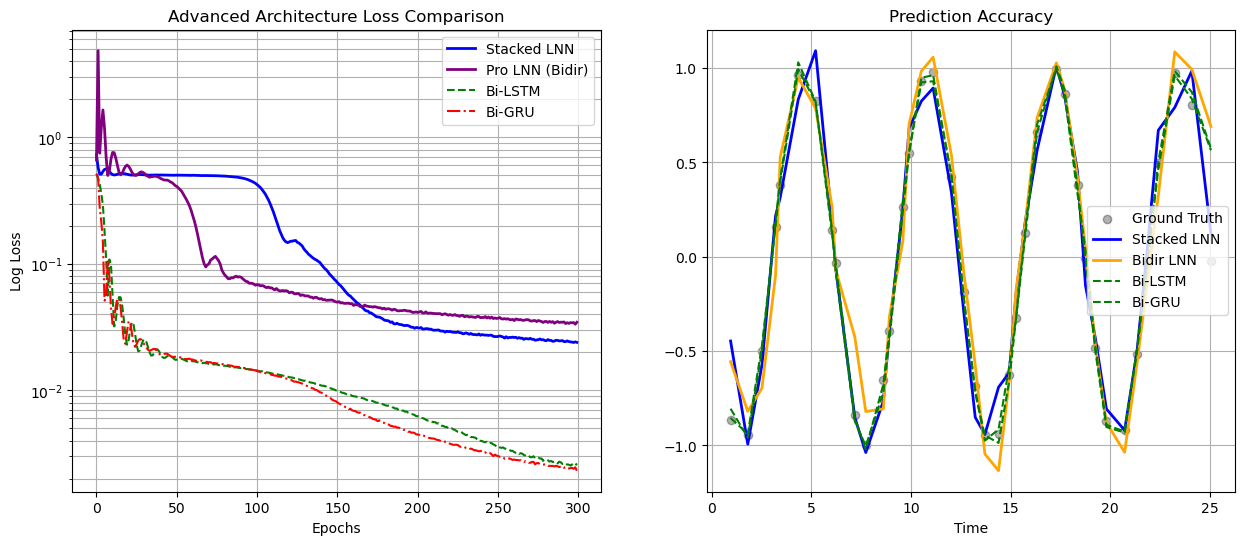

In [25]:
# ==========================================
# ADVANCED PLOTTING
# ==========================================
plt.figure(figsize=(15, 6))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(loss_lnn, label='Stacked LNN', linewidth=2, color='blue')
plt.plot(loss_pro, label='Pro LNN (Bidir)', color='purple', linewidth=2)
plt.plot(loss_lstm, label='Bi-LSTM', linestyle='--', color='green')
plt.plot(loss_gru, label='Bi-GRU', linestyle='-.', color='red')
plt.title('Advanced Architecture Loss Comparison')
plt.yscale('log') # Log scale helps see small differences
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True, which="both", ls="-")

# Plot 2: Prediction
plt.subplot(1, 2, 2)
idx = 0
time_axis = np.cumsum(T[idx].cpu().numpy())
plt.scatter(time_axis, Y[idx].cpu().numpy(), label='Ground Truth', color='black', alpha=0.3)
plt.plot(time_axis, pred_lnn[idx].cpu().detach().numpy(), label='Stacked LNN', color='blue', linewidth=2)
plt.plot(time_axis, pred_pro[idx].cpu().detach().numpy(), label='Bidir LNN', color='orange', linewidth=2)
plt.plot(time_axis, pred_lstm[idx].cpu().detach().numpy(), label='Bi-LSTM', color='green', linestyle='--')
plt.plot(time_axis, pred_gru[idx].cpu().detach().numpy(), label='Bi-GRU', color='green', linestyle='--')
plt.title('Prediction Accuracy')
plt.xlabel('Time')
plt.legend()
plt.grid(True)

plt.show()

## Test data

In [38]:
# ==========================================
# 1. OOD TEST DATA GENERATOR
# ==========================================
def generate_morphing_data(n_samples=500, seq_len=100):
    """
    Generates data that changes frequency and amplitude over time.
    This simulates 'real world' non-stationary dynamics.
    """
    X = []
    Y = []
    T = []

    for _ in range(n_samples):
        # Start at a random time
        t_curr = np.random.rand() * 10
        
        x_seq = []
        y_seq = []
        t_deltas = []
        
        # Initial Physics Parameters
        freq = 1.0
        amp = 1.0
        phase = 0.0
        
        for i in range(seq_len + 1): # +1 because we need target for next step
            # 1. Randomly change physics every 20 steps
            if i % 20 == 0 and i > 0:
                freq = np.random.choice([0.5, 1.0, 2.0, 3.0, 5.0]) # Slow, Normal, Fast, Very Fast
                amp = np.random.choice([0.5, 1.0, 1.5, 2.0, 2.5])       # Small, Normal, Tall
            
            # 2. Time Step (Irregular)
            dt = np.random.rand() * 0.5 + 0.1 # Varying sampling rate
            t_curr += dt
            
            # 3. Calculate Value
            # We integrate phase because freq changes: phase_new = phase_old + freq * dt
            phase += freq * dt
            val = amp * np.sin(phase)
            
            if i < seq_len:
                x_seq.append(val)
                t_deltas.append(dt)
            else:
                # This is the target for the last input
                last_target = val
        
        # Create Targets (Shifted by 1)
        # Input: [x0, x1, ... x_last-1]
        # Target: [x1, x2, ... x_last]
        inputs = np.array(x_seq)
        targets = np.array(x_seq[1:] + [last_target])
        
        X.append(inputs[:, None])
        Y.append(targets[:, None])
        T.append(np.array(t_deltas)[:, None])

    return (torch.FloatTensor(np.array(X)).to(device), 
            torch.FloatTensor(np.array(Y)).to(device), 
            torch.FloatTensor(np.array(T)).to(device))

# Generate the Test Set
print("Generating OOD Test Data...")
test_X, test_Y, test_T = generate_morphing_data(n_samples=20, seq_len=50)
print(f"Test Data Shape: {test_X.shape}")

Generating OOD Test Data...
Test Data Shape: torch.Size([20, 50, 1])


### Predicting

In [39]:
# ==========================================
# 2. VALIDATION FUNCTION
# ==========================================
def evaluate_model(model, X, T, Y):
    model.eval() # Set to evaluation mode (turns off Dropout)
    with torch.no_grad():
        if "LNN" in str(type(model)):
            pred = model(X, T)
        else:
            pred = model(X) # LSTM/GRU ignore T
        
        mse = nn.MSELoss()(pred, Y).item()
    return mse, pred

# ==========================================
# 3. RUN EVALUATION
# ==========================================
models = {
    "Stacked LNN": adv_lnn,
    "Pro LNN (Bidir)": pro_lnn,
    "Bi-LSTM": adv_lstm,
    "Bi-GRU": adv_gru
}

results = {}
predictions = {}

print("\n--- Validation Results (MSE Loss) ---")
for name, model in models.items():
    mse, pred = evaluate_model(model, test_X, test_T, test_Y)
    results[name] = mse
    predictions[name] = pred
    print(f"{name}: {mse:.5f}")


--- Validation Results (MSE Loss) ---
Stacked LNN: 0.54718
Pro LNN (Bidir): 0.31912
Bi-LSTM: 0.09419
Bi-GRU: 0.09973


### Plotting

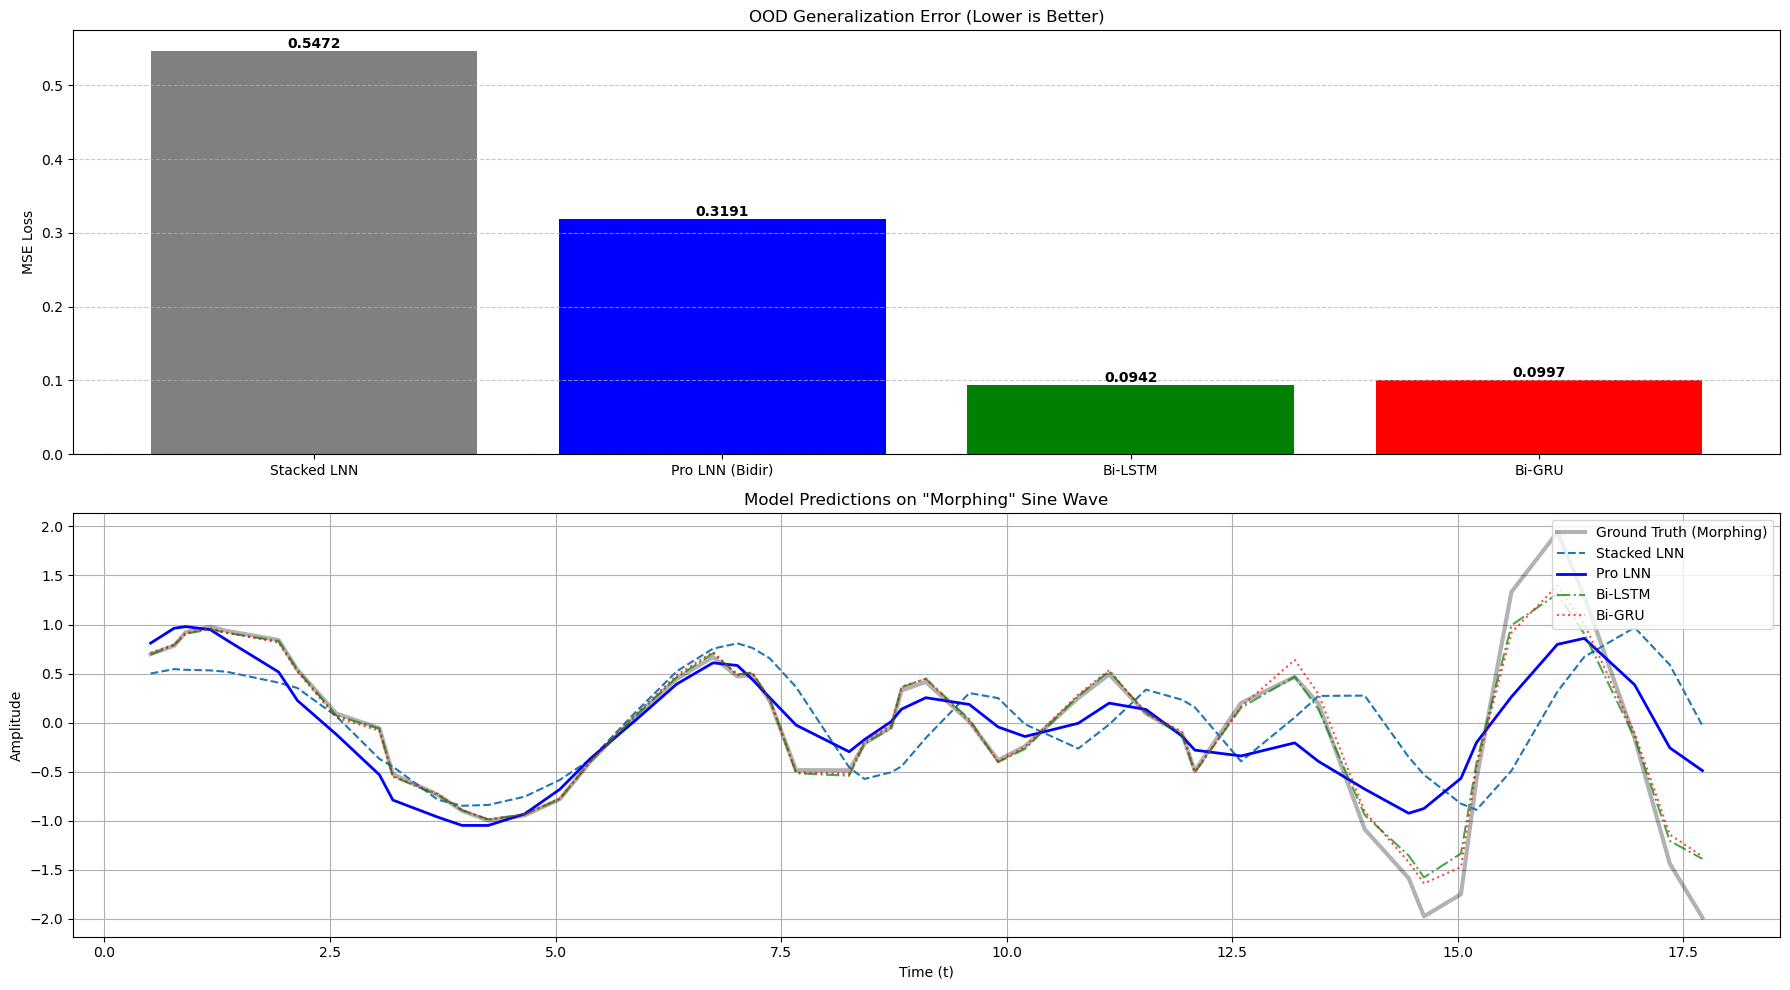

In [40]:
# ==========================================
# 4. PLOTTING
# ==========================================
plt.figure(figsize=(18, 10))

# Plot 1: Bar Chart of Errors
plt.subplot(2, 1, 1)
bars = plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'green', 'red'])
plt.title('OOD Generalization Error (Lower is Better)')
plt.ylabel('MSE Loss')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontweight='bold')

# Plot 2: Trajectory Visualization
plt.subplot(2, 1, 2)
idx = 10 # Pick a random sample index
time_axis = np.cumsum(test_T[idx].cpu().numpy())

# Plot Ground Truth
plt.plot(time_axis, test_Y[idx].cpu().numpy(), label='Ground Truth (Morphing)', color='black', linewidth=3, alpha=0.3)

# Plot Predictions
plt.plot(time_axis, predictions["Stacked LNN"][idx].cpu().numpy(), label='Stacked LNN', linestyle='--')
plt.plot(time_axis, predictions["Pro LNN (Bidir)"][idx].cpu().numpy(), label='Pro LNN', color='blue', linewidth=2)
plt.plot(time_axis, predictions["Bi-LSTM"][idx].cpu().numpy(), label='Bi-LSTM', color='green', linestyle='-.', alpha=0.7)
plt.plot(time_axis, predictions["Bi-GRU"][idx].cpu().numpy(), label='Bi-GRU', color='red', linestyle=':', alpha=0.7)

plt.title('Model Predictions on "Morphing" Sine Wave')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()